# Test JulES

### Import packages

In [1]:
using Pkg;
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"TuLiPa")); Pkg.status() # go to development version
# Pkg.undo(); Pkg.status() # go back to main package version
# Pkg.add(url="https://github.com/NVE/TuLiPa.git"); Pkg.status() # alternative go back to latest version

In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, CSV, Plots, PrettyTables
#plotlyjs(); uncomment for interactive plots

In [3]:
config = YAML.load_file(joinpath(dirname(dirname(pwd())), "JulESIO", "config_jules_vassdrag.yml"))
scenarioyear = 1981
datayear = 2021

2021

### Prepare parallell processing - import code on all cores

In [4]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 1


In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(dirname(pwd()))),"jgrc/TuLiPa/src/TuLiPa.jl"));

In [6]:
@everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

In [7]:
function getdataset(config, scenarioyear)
    settings = config[config["main"]["settings"]]

    # Read watercourse, elspot area and price series
    watercourse = config["data"]["watercourse"]
    elspotnames = config["data"]["elspotnames"] # some watercourses are in several elspot areas
    priceseriesname = config["data"]["priceseriesname"] 

    # Read hydropower dataelements from json-files
    sti_dynmodelldata = joinpath(config["main"]["input"], "dataset_vassdrag")
    tidsserie = JSON.parsefile(joinpath(sti_dynmodelldata,"tidsserier_detd.json"))
    detdseries = getelements(tidsserie, sti_dynmodelldata);
    dst = JSON.parsefile(joinpath(sti_dynmodelldata, "dataset_detd_" * watercourse * ".json"))
    detdstructure = getelements(dst);
    elements = vcat(detdseries,detdstructure)

    # Add an exogenous price area that the plants and pumps can interact with. All units are in NO5.
    for elspotname in elspotnames
        addexogenbalance!(elements, "PowerBalance_" * elspotname, "Power", "AreaPrice")
    end

    # Add dataelements for price in exogen area
    price_path = joinpath(config["main"]["input"], config["data"]["price"])
    df = CSV.read(price_path, DataFrame; header=3, decimal=',', types=Float64)
    df[:,"aar"] = cld.(1:first(size(df)), 2912) .+ 1957
    df[:,"tsnitt"] = rem.(0:(first(size(df))-1), 2912) .+ 1
    df.datetime .= getisoyearstart.(Int.(df.aar)) + Hour.((df.tsnitt.-1)*3) # TODO: Include week 53. Now ignored and flat prices.
    push!(elements, DataElement(TIMEINDEX_CONCEPT,"VectorTimeIndex","AreaPriceProfileIndex",
            Dict("Vector" => df.datetime)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT,"VectorTimeValues","AreaPriceProfileValues",
            Dict("Vector" => df[:,priceseriesname])))
    push!(elements, getelement(TIMEVECTOR_CONCEPT,"RotatingTimeVector","AreaProfile",
            (TIMEINDEX_CONCEPT,"AreaPriceProfileIndex"),(TIMEVALUES_CONCEPT,"AreaPriceProfileValues")))
    addparam!(elements, "MeanSeriesIgnorePhaseinParam", "AreaPrice", 1.0, "AreaProfile")

    return Dict("elements" => elements, "detailedrescopl" => Dict())
end

dataset = getdataset(config, scenarioyear)

Dict{String, Any} with 2 entries:
  "elements"        => DataElement[DataElement("TimeDelta", "MsTimeDelta", "Day…
  "detailedrescopl" => Dict{Any, Any}()

In [8]:
data = JulES.run_serial(config, datayear, scenarioyear, dataset)

Time parameters
  0.030176 seconds (1.38 k allocations: 91.345 KiB, 99.34% compilation time)
Get data
  0.000030 seconds (9 allocations: 656 bytes)
Make dummy objects


  0.913015 seconds (489.30 k allocations: 32.423 MiB, 7.11% gc time, 97.55% compilation time)
Init scenario modelling for simulation, prognosis and stochastic


  3.297692 seconds (519.49 k allocations: 27.615 MiB, 99.96% compilation time)
  3.342516 seconds (529.43 k allocations: 28.272 MiB, 99.95% compilation time)
Init stochastic


  0.255594 seconds (219.65 k allocations: 14.001 MiB, 94.94% compilation time)


  6.689050 seconds (2.96 M allocations: 197.788 MiB, 2.04% gc time, 99.02% compilation time: <1% of which was recompilation)


  0.077562 seconds (46.34 k allocations: 3.152 MiB, 99.65% compilation time)


 10.431996 seconds (4.36 M allocations: 289.661 MiB, 1.79% gc time, 99.03% compilation time: <1% of which was recompilation)
Init results


  1.384645 seconds (541.93 k allocations: 36.471 MiB, 3.30% gc time, 99.80% compilation time)
Simulate forward


FixedDataTwoTime(

DateTime("2021-01-04T00:00:00"), DateTime("1980-12-31T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-02T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-04T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-06T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-08T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-10T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-12T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-14T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-16T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-18T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-20T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-22T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-24T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-26T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-28T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-01-30T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-01T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-03T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-05T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-07T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-09T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-11T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-13T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-15T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-17T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-19T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-21T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-23T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-25T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-02-27T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-01T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-03T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-05T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-07T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-09T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-11T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-13T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-15T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-17T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-19T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-21T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-23T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-25T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-27T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-29T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-03-31T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-02T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-04T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-06T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-08T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-10T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-12T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-14T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-16T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-18T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-20T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-22T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-24T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-26T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-28T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-04-30T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-02T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-04T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-06T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-08T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-10T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-12T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-14T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-16T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-18T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-20T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-22T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-24T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-26T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-28T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-05-30T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-01T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-03T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-05T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-07T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-09T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-11T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-13T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-15T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-17T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-19T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-21T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-23T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-25T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-27T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-06-29T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-01T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-03T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-05T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-07T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-09T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-11T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-13T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-15T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-17T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-19T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-21T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-23T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-25T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-27T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-29T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-07-31T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-02T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-04T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-06T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-08T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-10T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-12T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-14T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-16T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-18T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-20T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-22T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-24T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-26T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-28T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-08-30T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-01T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-03T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-05T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-07T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-09T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-11T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-13T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-15T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-17T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-19T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-21T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-23T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-25T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-27T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-09-29T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-01T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-03T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-05T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-07T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-09T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-11T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-13T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-15T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-17T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-19T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-21T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-23T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-25T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-27T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-29T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-10-31T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-02T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-04T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-06T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-08T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-10T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-12T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-14T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-16T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-18T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-20T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-22T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-24T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-26T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-28T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-11-30T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-02T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-04T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-06T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-08T00:00:00")

)
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-10T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-12T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-14T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-16T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-18T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-20T00:00:00"))


FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-22T00:00:00"))
FixedDataTwoTime(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-24T00:00:00"))
FixedDataTwoTime

(DateTime("2021-01-04T00:00:00"), DateTime("1981-12-26T00:00:00"))
The simulation took: 0.11694893833333334 minutes
Time usage per timestep: 0.03855459505494506 seconds
Handle output

Row,umaster,usub,conv,count,smaster,ssub,hlmaster,wwres,total,short,core
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Int64
1,0.00011891,0.00776353,0.0143949,1.95028,0.000854151,0.0130129,0.000247077,4.92122e-5,0.0243318,false,1


Row,core,umaster_sum,usub_sum,conv_sum,count_sum,smaster_sum,ssub_sum,hlmaster_sum,wwres_sum,total_sum
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.00011891,0.00776353,0.0143949,1.95028,0.000854151,0.0130129,0.000247077,4.92122e-5,0.0243318


9-element Vector{Float64}:
 0.00011890994475138122
 0.007763532044198896
 0.014394888397790058
 1.9502762430939227
 0.0008541513812154696
 0.01301286408839779
 0.00024707679558011046
 4.9212154696132595e-5
 0.024331755248618782

 13.198500 seconds (9.26 M allocations: 602.753 MiB, 3.65% gc time, 99.61% compilation time: 6% of which was recompilation)


Dict{Any, Any} with 25 entries:
  "svindex"            => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "demandbalancenames" => SubString{String}[]
  "skipfactor"         => 1.0
  "stochastictimes"    => [0.000157 0.0139952 … 8.24e-5 0.257086; 0.0001139 0.0…
  "resindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "areanames"          => ["NO4"]
  "priceindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "batmatrix"          => Matrix{Float64}(undef, 364, 0)
  "stateindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "statematrix"        => [8.0 9.0 … 8.0 3506.0; 7.00606 9.0 … 8.0 3506.0; … ; …
  "statenames"         => ["Reservoir_67301", "Reservoir_67306_max", "Reservoir…
  "resnames"           => ["Reservoir_67301", "Reservoir_67302", "Reservoir_673…
  "shorts"             => Bool[0, 0, 0]
  "demandvalues"       => Matrix{Float64}(undef, 364, 0)
  "batindex"           => [DateTime("1980-12-29T00:00:00

In [9]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = data["statematrix"]
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"]

storagevalues = data["storagevalues"]
storagenames = data["storagenames"]
scenarionames = data["scenarionames"];

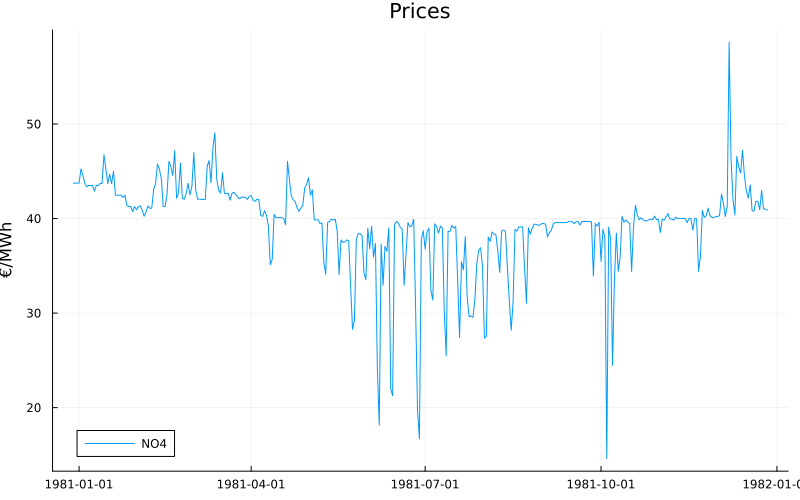

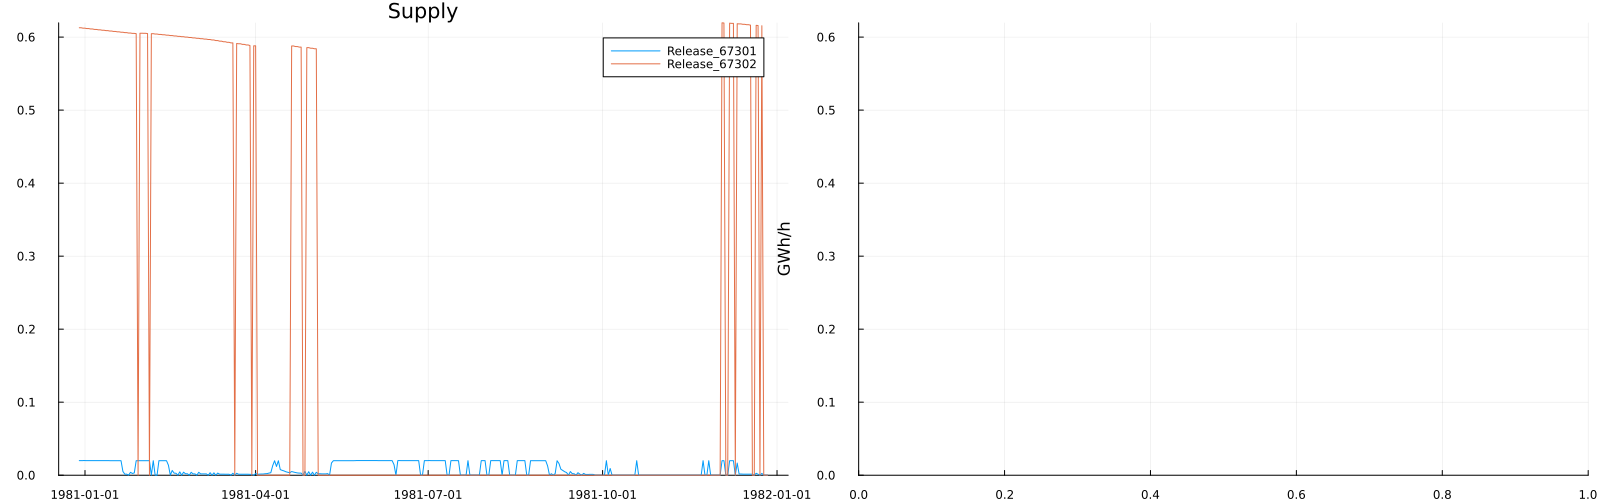

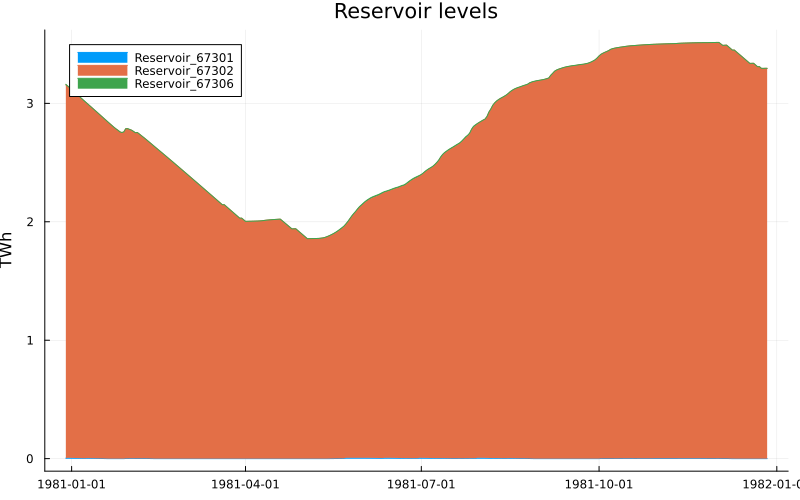

┌───────────────┬───────────────────┬────────────┬───────────────────┐
│    Supplyname │ Yearly_supply_TWh │ Demandname │ Yearly_demand_TWh │
├───────────────┼───────────────────┼────────────┼───────────────────┤
│ Release_67302 │           1.71016 │    missing │           missing │
│ Release_67301 │         0.0750302 │    missing │           missing │
└───────────────┴───────────────────┴────────────┴───────────────────┘


┌───────────────────────────────────┬───────────────────────────────────┐
│ Yearly_supply_TWh_sum_skipmissing │ Yearly_demand_TWh_sum_skipmissing │
├───────────────────────────────────┼───────────────────────────────────┤
│                           1.78519 │                               0.0 │
└───────────────────────────────────┴───────────────────────────────────┘


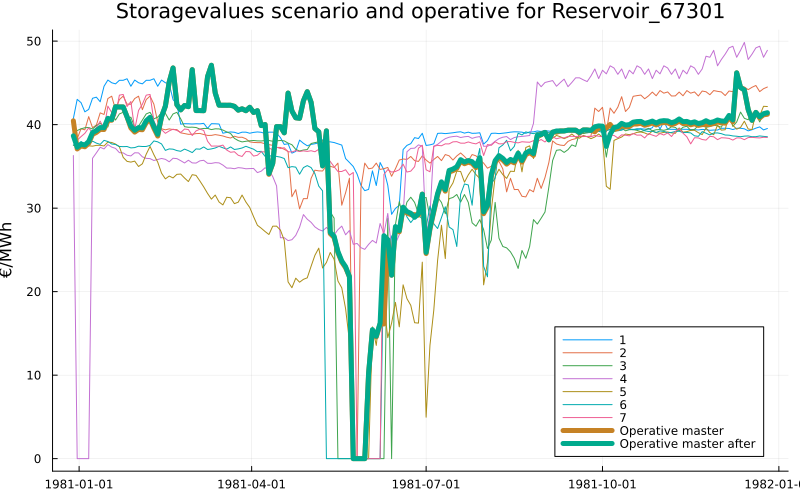

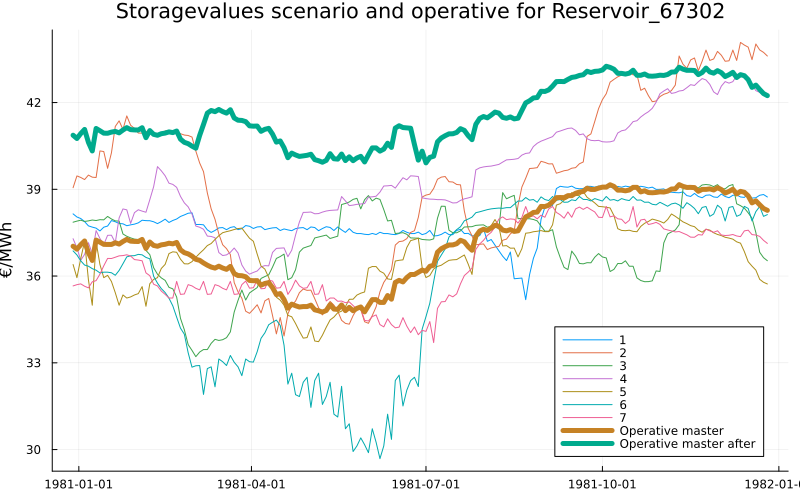

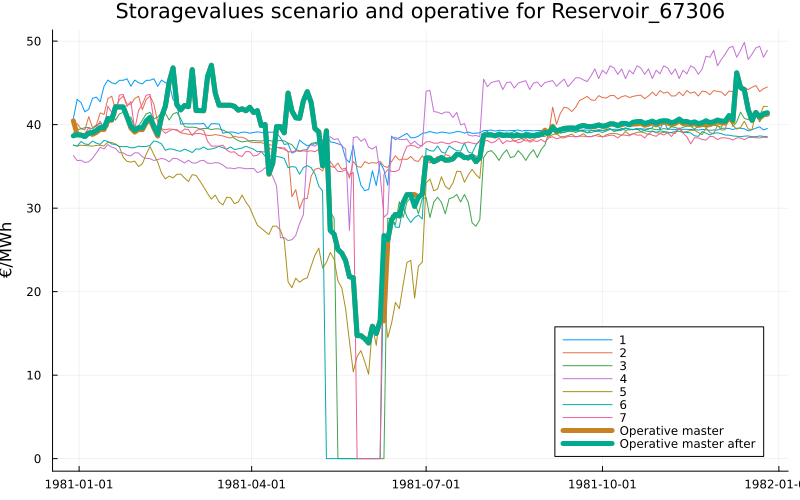

┌───────────────┬──────────────────┬────────────┬───────────────────┐
│    Supplyname │ Yearly_rev_mill€ │ Demandname │ Yearly_cost_mill€ │
├───────────────┼──────────────────┼────────────┼───────────────────┤
│ Release_67302 │          74.2813 │    missing │           missing │
│ Release_67301 │          2.96561 │    missing │           missing │
└───────────────┴──────────────────┴────────────┴───────────────────┘
┌──────────────────────────────────┬───────────────────────────────────┐
│ Yearly_rev_mill€_sum_skipmissing │ Yearly_cost_mill€_sum_skipmissing │
├──────────────────────────────────┼───────────────────────────────────┤
│                          77.2469 │                               0.0 │
└──────────────────────────────────┴───────────────────────────────────┘


In [10]:
# Plot prices
display(plot(x1, prices, labels=reshape(powerbalancenames,1,length(powerbalancenames)), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
display(plot([supplychart,demandchart]...,layout=(1,2),size=(1600,500)))

# Plot storages
display(areaplot(x2, hydrolevels,labels=reshape(hydronames,1,length(hydronames)),size=(800,500),title="Reservoir levels", ylabel = "TWh")) #
# display(areaplot(x2, dropdims(sum(hydrolevels,dims=2),dims=2),labels="Total reservoirs",size=(800,500),title="Reservoir levels", ylabel = "Gm3")) #

# Plot list of yearly mean production and demand for each supply/demand
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
pretty_table(joineddf, show_subheader=false)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader=false)

# Plot list of yearly income and cost for each supply/demand
supplyrev = copy(supplyvalues)
for (i,supplybalancename) in enumerate(supplybalancenames)
    idx = findfirst(isequal(supplybalancename), powerbalancenames)
    supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
end
demandrev = copy(demandvalues)
for (i,demandbalancename) in enumerate(demandbalancenames)
    idx = findfirst(isequal(demandbalancename), powerbalancenames)
    demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
end
meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
supplyrevdf[!,:ID] = collect(1:length(supplynames))
demandrevdf[!,:ID] = collect(1:length(demandnames))
joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
pretty_table(joinedrevdf, show_subheader=false)

# Sum revenues and cost
pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader=false)

# Plot storagevalues for each reservoir and scenarios
numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
numscen = length(scenarionames) - numop
for (i, storagename) in enumerate(storagenames)
    p = plot(x3, storagevalues[:,1:numscen,i] / -1, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numscen], 1, numscen), ylabel="€/MWh")
    plot!(p, x3, storagevalues[:,numscen+1:end,i] / -1, labels=reshape(scenarionames[numscen+1:end], 1, numop), linewidth=5)
    display(p)
 end